<a href="https://colab.research.google.com/github/mit1280/Document-AI/blob/main/UDOPEncoderModel_fine_tune_DocLayNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
!pip install -q datasets sentencepiece bitsandbytes datasets seqeval
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.2/102.2 MB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 41.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 42.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 48.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.

In [ ]:
from transformers import UdopForConditionalGeneration
from PIL import Image
import torch
from datasets import load_dataset
from datasets.features import ClassLabel
from PIL import ImageDraw, ImageFont
import random
from huggingface_hub import notebook_login

In [ ]:
from transformers import UdopForConditionalGeneration, AutoProcessor, AutoModelForTokenClassification
#
model_name = "microsoft/udop-large"
# model = UdopForConditionalGeneration.from_pretrained(model_name, ignore_mismatched_sizes=True)
processor = AutoProcessor.from_pretrained(model_name, apply_ocr = False)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/759 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/238k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/29.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/24.1k [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
notebook_login()

In [ ]:
# Load dataset from huggingface https://huggingface.co/datasets/pierreguillou/DocLayNet-small
# DocLayNet is present in three size: small, base, large
# We will use small as we have only 15 GB RAM in colab
dataset_id ="pierreguillou/DocLayNet-small"

dataset = load_dataset(dataset_id)

print(f"Train dataset size: {len(dataset['train'])}")
print(f"Test dataset size: {len(dataset['test'])}")
print(f"Test dataset size: {len(dataset['validation'])}")

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1461: FutureWarning: The repository for pierreguillou/DocLayNet-small contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/pierreguillou/DocLayNet-small
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Train dataset size: 691
Test dataset size: 49
Test dataset size: 64


In [ ]:
def remove_duplicates_with_concatenation_and_sorting(text_list, bounding_boxes, labels):
    # Create a dictionary to store text concatenated with bounding boxes as keys
    bounding_box_dict = {}

    # Iterate through the bounding boxes and text lists
    for text, bbox, label in zip(text_list, bounding_boxes, labels):
        # Convert bounding box to tuple to use as dictionary key
        bbox_key = tuple(bbox)

        # If the bounding box key already exists in the dictionary, concatenate the text
        if bbox_key in bounding_box_dict:
            bounding_box_dict[bbox_key] = (bounding_box_dict[bbox_key][0] + ' ' + text, label)
        else:
            bounding_box_dict[bbox_key] = (text, label)

    # Extract unique bounding boxes, concatenated text, and labels
    unique_bounding_boxes = list(bounding_box_dict.keys())
    concatenated_text = [bounding_box_dict[bbox_key][0] for bbox_key in unique_bounding_boxes]
    unique_labels = [bounding_box_dict[bbox_key][1] for bbox_key in unique_bounding_boxes]

    return concatenated_text, unique_bounding_boxes, unique_labels

In [ ]:
def get_labels(example):
    example['set_texts'], example['set_bbox_block'], example['set_labels'] = remove_duplicates_with_concatenation_and_sorting(example['texts'], example['bboxes_block'], example['categories'])
    example['set_image'] = example['image'].resize((1000, 1000))
    return example

In [ ]:
# Remove data which has no text
dataset = dataset.filter(lambda example: len(example['texts']) > 0)

Filter:   0%|          | 0/691 [00:00<?, ? examples/s]

Filter:   0%|          | 0/64 [00:00<?, ? examples/s]

Filter:   0%|          | 0/49 [00:00<?, ? examples/s]

In [ ]:
dataset = dataset.map(get_labels)

Map:   0%|          | 0/688 [00:00<?, ? examples/s]

Map:   0%|          | 0/63 [00:00<?, ? examples/s]

Map:   0%|          | 0/49 [00:00<?, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'texts', 'bboxes_block', 'bboxes_line', 'categories', 'image', 'page_hash', 'original_filename', 'page_no', 'num_pages', 'original_width', 'original_height', 'coco_width', 'coco_height', 'collection', 'doc_category', 'set_texts', 'set_bbox_block', 'set_labels', 'set_image'],
        num_rows: 688
    })
    validation: Dataset({
        features: ['id', 'texts', 'bboxes_block', 'bboxes_line', 'categories', 'image', 'page_hash', 'original_filename', 'page_no', 'num_pages', 'original_width', 'original_height', 'coco_width', 'coco_height', 'collection', 'doc_category', 'set_texts', 'set_bbox_block', 'set_labels', 'set_image'],
        num_rows: 63
    })
    test: Dataset({
        features: ['id', 'texts', 'bboxes_block', 'bboxes_line', 'categories', 'image', 'page_hash', 'original_filename', 'page_no', 'num_pages', 'original_width', 'original_height', 'coco_width', 'coco_height', 'collection', 'doc_category', 'set_texts', 'set_

In [ ]:
features = dataset["train"].features
column_names = dataset["train"].column_names
image_column_name = "norm_image"
text_column_name = "texts"
# boxes_block_column_name = "bboxes_block"
boxes_line_column_name = "set_norm_blocks_box"
label_column_name = "categories"

# In the event the labels are not a `Sequence[ClassLabel]`, we will need to go through the dataset to get the
# unique labels.
def get_label_list(labels):
    unique_labels = set()
    for label in labels:
        unique_labels = unique_labels | set(label)
    label_list = list(unique_labels)
    label_list.sort()
    return label_list

if isinstance(features[label_column_name].feature, ClassLabel):
    label_list = features[label_column_name].feature.names
    # No need to convert the labels since they are already ints.
    id2label = {k: v for k,v in enumerate(label_list)}
    label2id = {v: k for k,v in enumerate(label_list)}
else:
    label_list = get_label_list(dataset["train"][label_column_name])
    id2label = {k: v for k,v in enumerate(label_list)}
    label2id = {v: k for k,v in enumerate(label_list)}
num_labels = len(label_list)

In [ ]:
print(label_list)

['Caption', 'Footnote', 'Formula', 'List-item', 'Page-footer', 'Page-header', 'Picture', 'Section-header', 'Table', 'Text', 'Title']


In [ ]:
print(id2label)

{0: 'Caption', 1: 'Footnote', 2: 'Formula', 3: 'List-item', 4: 'Page-footer', 5: 'Page-header', 6: 'Picture', 7: 'Section-header', 8: 'Table', 9: 'Text', 10: 'Title'}


In [ ]:
# Normalize box diamentions to range 0 to 1000
def normalized_box(box, image_width=1025, image_height=1025):
    return [
        int(1000 * (box[0] / image_width)),
        int(1000 * (box[1] / image_height)),
        int(1000 * (box[2] / image_width)),
        int(1000 * (box[3] / image_height)),
    ]
def convert_box(bbox):
    x, y, w, h = tuple(bbox) # Box coordinates are in (left, top, width, height) format
    return [x, y, x+w, y+h] # we need to convert it into (x1, y1, x2, y2) which is (left, top, left+widght, top+height)

In [ ]:
example = dataset['train'][0]

In [ ]:
example.keys()

dict_keys(['id', 'texts', 'bboxes_block', 'bboxes_line', 'categories', 'image', 'page_hash', 'original_filename', 'page_no', 'num_pages', 'original_width', 'original_height', 'coco_width', 'coco_height', 'collection', 'doc_category', 'set_texts', 'set_bbox_block', 'set_labels', 'set_image'])

## Visualize

In [ ]:
coco_width = example['coco_width']
coco_height = example['coco_height']
categories_list = example['categories']
bboxs_list = example['bboxes_block']
original_width, original_height = example["original_width"], example["original_height"]
image = example['image']
resized_image = image.resize(size=(1000,1000))
image_width, image_height = image.size

draw_1 = ImageDraw.Draw(image, "RGBA")

In [ ]:
(image_width, image_height), (coco_width,coco_height), (original_width, original_height)

((1025, 1025), (1025, 1025), (609, 793))

In [ ]:
# Define colors for all labels
get_colors = lambda n: list(map(lambda i: "#" + "%06x" % random.randint(0, 0xFFFFFF),range(n)))
colors = get_colors(len(label_list))
font = ImageFont.load_default()
label2color = {label: colors[idx] for idx, label in enumerate(label_list)}

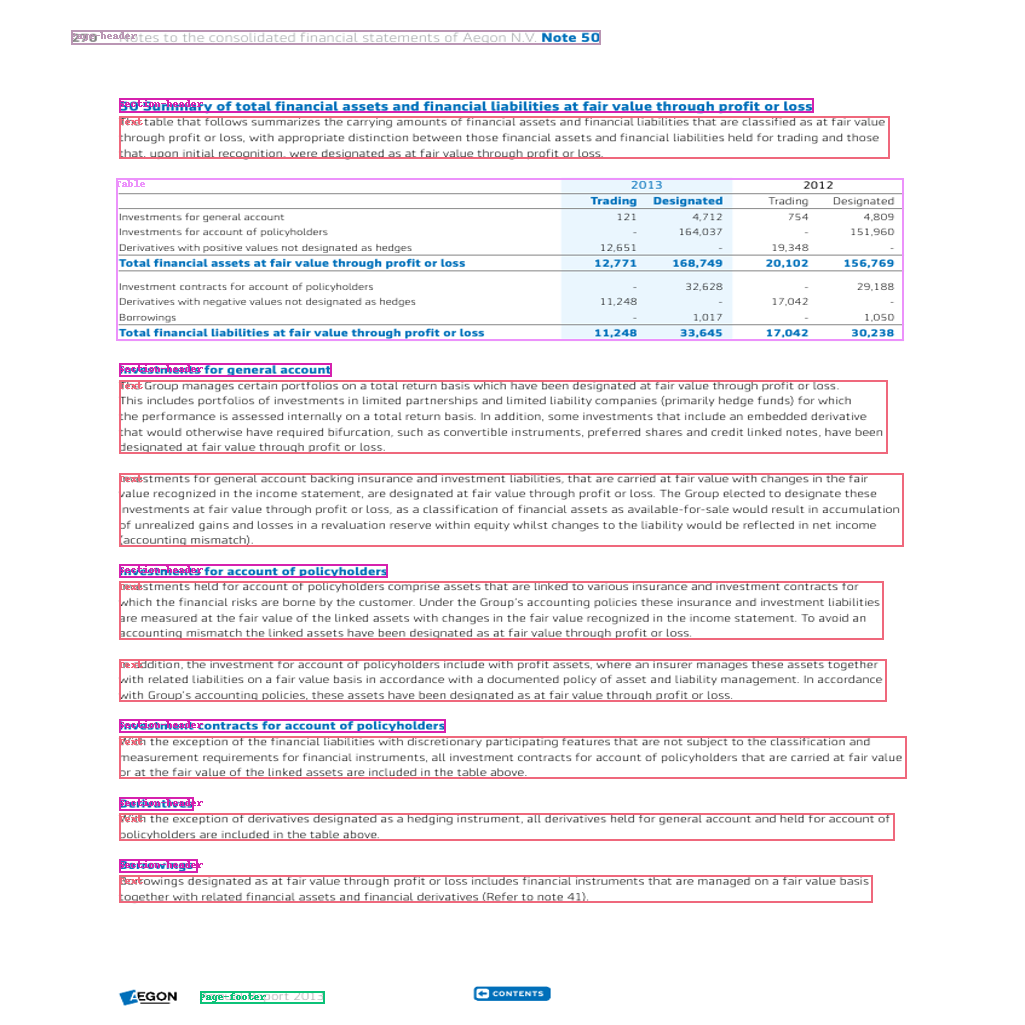

In [ ]:
# We are visulizing boxes on original imag
for categorie, box in zip( categories_list, bboxs_list):
    x, y, w, h = tuple(box) # the row comes in (left, top, width, height) format
    box = [x, y, x+w, y+h]
    draw_1.rectangle(box, outline=label2color[id2label[categorie]], width=2)
    draw_1.text((box[0], box[1]), id2label[categorie], fill=label2color[id2label[categorie]], font=font, size=20)

image

## Feature

In [ ]:
def prepare_examples(examples):
  images = examples['set_image']
  words = examples['set_texts']
  boxes = examples['set_bbox_block']
  word_labels = examples['set_labels']
  norm_box = []
  for box in boxes:
    temp_list = [normalized_box(convert_box(i)) for i in box]
    norm_box.append(temp_list)

  encoding = processor(images, words, boxes=norm_box, word_labels=word_labels,
                       truncation=True, padding="max_length", max_length=512)

  return encoding

In [ ]:
from datasets import Features, Sequence, ClassLabel, Value, Array2D, Array3D

# we need to define custom features for `set_format` (used later on) to work properly
features = Features({
    'pixel_values': Array3D(dtype="float32", shape=(3, 224, 224)),
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'attention_mask': Sequence(Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'labels': Sequence(feature=Value(dtype='int64')),
})

In [ ]:
train_dataset = dataset["train"].map(
    prepare_examples,
    batched=True,
    remove_columns=column_names,
    features=features,
    # batch_size=8,
)
eval_dataset = dataset["test"].map(
    prepare_examples,
    batched=True,
    remove_columns=column_names,
    features=features,
    # batch_size=8,
)
val_dataset = dataset["validation"].map(
    prepare_examples,
    batched=True,
    remove_columns=column_names,
    features=features,
    # batch_size=8,
)

Map:   0%|          | 0/688 [00:00<?, ? examples/s]

Map:   0%|          | 0/49 [00:00<?, ? examples/s]

Map:   0%|          | 0/63 [00:00<?, ? examples/s]

In [ ]:
train_dataset

Dataset({
    features: ['pixel_values', 'input_ids', 'attention_mask', 'bbox', 'labels'],
    num_rows: 688
})

In [ ]:
example = train_dataset[0]
processor.tokenizer.decode(example["input_ids"])

'Notes to the consolidated financial statements of Aegon N.V. Note 50 270 50 Summary of total financial assets and financial liabilities at fair value through profit or loss Investments for general account Investments for account of policyholders Investment contracts for account of policyholders Derivatives Borrowings The table that follows summarizes the carrying amounts of financial assets and financial liabilities that are classified as at fair value through profit or loss, with appropriate distinction between those financial assets and financial liabilities held for trading and those that, upon initial recognition, were designated as at fair value through profit or loss. The Group manages certain portfolios on a total return basis which have been designated at fair value through profit or loss. This includes portfolios of investments in limited partnerships and limited liability companies (primarily hedge funds) for which the performance is assessed internally on a total return bas

In [ ]:
train_dataset.set_format("torch")

In [ ]:
import torch

example = train_dataset[0]
for k,v in example.items():
    print(k,v.shape)

pixel_values torch.Size([3, 224, 224])
input_ids torch.Size([512])
attention_mask torch.Size([512])
bbox torch.Size([512, 4])
labels torch.Size([512])


In [ ]:
eval_dataset.set_format("torch")
val_dataset.set_format("torch")

In [ ]:
from datasets import load_metric

metric = load_metric("seqeval")

<ipython-input-13-edef154daec7>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("seqeval")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for seqeval contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/seqeval/seqeval.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [ ]:
import numpy as np

return_entity_level_metrics = False

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    if return_entity_level_metrics:
        # Unpack nested dictionaries
        final_results = {}
        for key, value in results.items():
            if isinstance(value, dict):
                for n, v in value.items():
                    final_results[f"{key}_{n}"] = v
            else:
                final_results[key] = value
        return final_results
    else:
        return {
            "precision": results["overall_precision"],
            "recall": results["overall_recall"],
            "f1": results["overall_f1"],
            "accuracy": results["overall_accuracy"],
        }

In [ ]:
from transformers import UdopEncoderModel, UdopPreTrainedModel, UdopConfig
from transformers.modeling_outputs import TokenClassifierOutput
from torch import nn

class UdopForTokenClassification(UdopPreTrainedModel):
  def __init__(self, config):
    super().__init__(config)

    self.udop = UdopEncoderModel.from_pretrained(model_name)
    self.num_labels = config.num_labels

    self.dropout = nn.Dropout(0.5)
    self.classifier = nn.Linear(config.hidden_size, config.num_labels)

  def forward(self, input_ids, bbox, attention_mask, pixel_values, labels=None):
    outputs = self.udop(input_ids=input_ids, bbox=bbox, attention_mask=attention_mask, pixel_values=pixel_values)
    sequence_output = outputs[0]

    seq_length = input_ids.shape[1]
    # only take the text part of the output representations
    sequence_output = outputs[0][:, :seq_length]
    sequence_output = self.dropout(sequence_output)

    logits = self.classifier(sequence_output)

    loss = None
    if labels is not None:
        loss_fct = nn.CrossEntropyLoss()
        loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

    return TokenClassifierOutput(
        loss=loss,
        logits=logits,
        hidden_states=outputs.hidden_states,
        attentions=outputs.attentions,
    )

In [ ]:
config = UdopConfig(id2label=id2label, label2id=label2id)
model = UdopForTokenClassification(config)

config.json:   0%|          | 0.00/907 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.97G [00:00<?, ?B/s]

In [ ]:
from transformers import TrainingArguments, Trainer
log_eval_steps = 200
training_args = TrainingArguments(
                                    output_dir="./UDOP-finetuned-DocLayNet-1",# Output directory
                                    max_steps=800,                              # Maximum number of training steps
                                    per_device_train_batch_size=2,               # Batch size for training
                                    per_device_eval_batch_size=2,                # Batch size for evaluation
                                    gradient_accumulation_steps=8,
                                    eval_accumulation_steps=8,
                                    learning_rate=2e-5,                          # Learning rate for the optimizer
                                    evaluation_strategy="steps",                 # Evaluate every "eval_steps" steps
                                    eval_steps=log_eval_steps,                              # Evaluate every 250 steps
                                    save_strategy="steps",                       # Save checkpoints every "save_steps" steps
                                    save_steps=log_eval_steps,                             # Save checkpoints every 1000 steps
                                    logging_dir='./logs',                        # Directory for storing logs
                                    logging_steps=log_eval_steps,                           # Log every "logging_steps" steps
                                    load_best_model_at_end=True,                 # Load the best model when finished training
                                    metric_for_best_model="f1",            # Use accuracy as the metric to compare models
                                    greater_is_better = True,                     # Indicate whether the metric is to be maximized or minimized
                                    warmup_ratio=0.1, # we warmup a bit
                                    # fp16=True, # we use mixed precision (less memory consumption)
                                    push_to_hub=True, # after training, we'd like to push our model to the hub
                                    push_to_hub_model_id=f"UDOP-finetuned-DocLayNet-1", # this is the name we'll use for our model on the hub
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1847: FutureWarning: `--push_to_hub_model_id` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_model_id` instead and pass the full repo name to this argument (in this case Mit1208/UDOP-finetuned-DocLayNet-1).
  warnings.warn(


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)
device

'cuda'

In [ ]:
from transformers.data.data_collator import default_data_collator

# Initialize our Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=processor,
    data_collator=default_data_collator,
    compute_metrics=compute_metrics,
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [ ]:
trainer.train()

Step,Training Loss,Validation Loss


KeyboardInterrupt: 

In [ ]:
trainer.evaluate(val_dataset)

In [ ]:
trainer.push_to_hub()

CommitInfo(commit_url='https://huggingface.co/Mit1208/UDOP-finetuned-DocLayNet-1/commit/c0f76c37c8e4f5ab01147c9a0ca5d7024066f47a', commit_message='End of training', commit_description='', oid='c0f76c37c8e4f5ab01147c9a0ca5d7024066f47a', pr_url=None, pr_revision=None, pr_num=None)

## Reference
1. https://github.com/NielsRogge/Transformers-Tutorials/blob/master/UDOP/Fine_tune_UDOPEncoderModel_on_FUNSD_(HuggingFace_Trainer).ipynb
2. https://github.com/mit1280/Document-AI/blob/main/FineTuning_LayoutLMv3_Trainer_HF_DocLayNet.ipynb